In [26]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np
import preprocessing
import pandas as pd
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA     # optional, for visualisation / speed‑up
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import diagnoses




In [39]:
import importlib
importlib.reload(preprocessing)
importlib.reload(diagnoses)

<module 'diagnoses' from 'c:\\Users\\bdscu\\Desktop\\ISDC SP25\\diagnoses.py'>

In [3]:
# # Load and scale data
# df_unscaled = pd.read_csv(r"Preprocessed_Data\unscaled_filtered.csv", index_col=0)
# df_scaled, _ = preprocessing.scale_dataframe_standard(df_unscaled)

# # Dimensionality reduction with PCA (no UMAP)
# X_reduced = preprocessing.pca_umap_reduction(df_scaled, pca_components=0.95, umap_components=10, use_umap=True)
# df_reduced = pd.DataFrame(X_reduced, index=df_unscaled.index).dropna()

# # Ensure matching index for interpretation
# df_unscaled = df_unscaled.loc[df_reduced.index]


c:\Users\bdscu\Desktop\ISDC SP25\preprocessing.py:157: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5, cmap='Spectral', alpha=0.7)


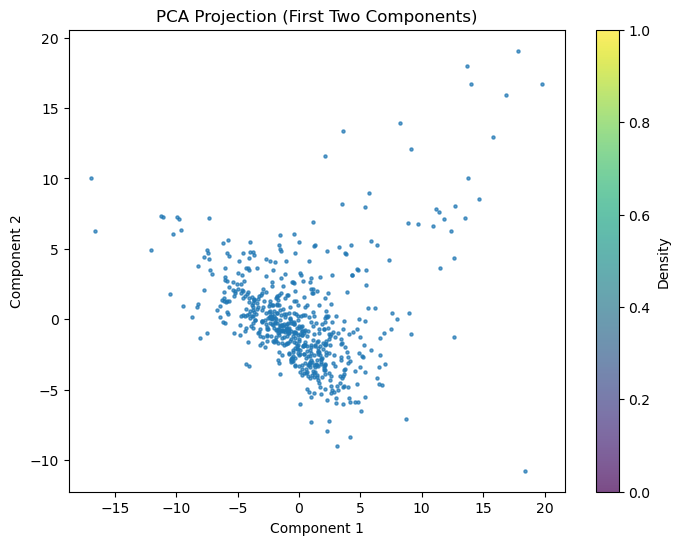

c:\Users\bdscu\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\bdscu\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\bdscu\Desktop\ISDC SP25\preprocessing.py:177: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(um.embedding_[:, comp1], um.embedding_[:, comp2], s=5, cmap='Spectral', alpha=0.7)


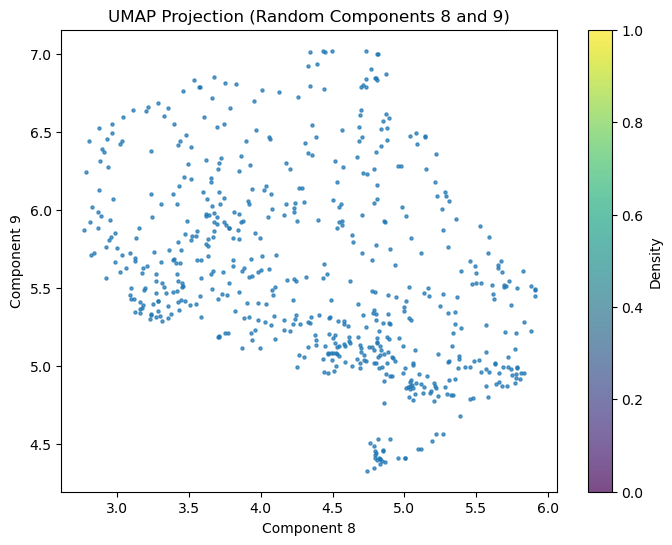

Original dimensions: (610, 95)
Reduced dimensions: (610, 10)


In [29]:
# Load and scale data with RobustScaler
df_unscaled = pd.read_csv(r"Preprocessed_Data\unscaled_filtered_retry.csv", index_col=0)
scaler = RobustScaler()
df_scaled_robust = pd.DataFrame(
    scaler.fit_transform(df_unscaled),
    columns=df_unscaled.columns,
    index=df_unscaled.index
)

# Dimensionality reduction
X_reduced = preprocessing.pca_umap_reduction(
    df_scaled_robust,
    pca_components=0.95,  # Keeps 95% of variance
    umap_components=10,   # Reduces to 10 dimensions
    use_umap=True
)


# Create DataFrame from reduced data
df_reduced = pd.DataFrame(X_reduced, index=df_unscaled.index).dropna()

# Ensure matching index for interpretation
df_unscaled = df_unscaled.loc[df_reduced.index]

print("Original dimensions:", df_scaled_robust.shape)
print("Reduced dimensions:", df_reduced.shape)

Find eps and min_samples

In [30]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid
import numpy as np
import pandas as pd
import diagnoses  # your module

# ---------------------------------------------------------------------
# 0. Parameters
# ---------------------------------------------------------------------
param_grid = {
    "eps": np.arange(0.05, 2, 0.05).tolist(),
    "min_samples": list(range(11, 30))
}

# Feature subset you care about
distinguishing_features = [
    "1s_critical_power_mean",
    "20m_critical_power_mean",
    "60m_critical_power_mean",
    "skiba_wprime_exp_mean",
    "a_skiba_variability_index_mean",
    "a_friel_efficiency_factor_mean",
    "aerobic_decoupling_mean",
    "vo2max_mean",
    "athlete_weight_mean",
    "a_skiba_bike_score_mean",
]

# ---------------------------------------------------------------------
# 1. Grid-search
# ---------------------------------------------------------------------
records   = []
n_total   = len(df_reduced)
X         = df_reduced.to_numpy(copy=False)      # immutable design-matrix
for params in ParameterGrid(param_grid):
    # --- fit DBSCAN ---------------------------------------------------
    db      = DBSCAN(**params, metric="euclidean", n_jobs=-1)
    labels  = db.fit_predict(X)

    # --- basic cluster diagnostics -----------------------------------
    n_clusters   = len(set(labels)) - (1 if -1 in labels else 0)
    sil          = (silhouette_score(
                        X[labels != -1], labels[labels != -1])
                    if n_clusters >= 2 else np.nan)
    pct_outliers = (labels == -1).sum() / n_total * 100

    # --- z-score matrix (fresh copy, no mutation) ---------------------
    df_lab        = df_unscaled.copy()
    df_lab["Cluster"] = labels
    z_df          = diagnoses.cluster_zscore_dataframe(df_lab,
                                                       cluster_col="Cluster")

    # --- counts for *all* numeric features ---------------------------
    abs_z         = z_df.abs().values.ravel()
    count_z_1_2   = np.sum((abs_z >= 1) & (abs_z < 2))
    count_z_2_3   = np.sum((abs_z >= 2) & (abs_z < 3))
    count_z_3_up  = np.sum(abs_z >= 3)

    # --- counts for distinguishing feature set -----------------------
    present_cols          = [c for c in distinguishing_features
                             if c in z_df.columns]
    abs_z_dist            = z_df[present_cols].abs().values.ravel()
    dist_count_z_1_2      = np.sum((abs_z_dist >= 1) & (abs_z_dist < 2))
    dist_count_z_2_3      = np.sum((abs_z_dist >= 2) & (abs_z_dist < 3))
    dist_count_z_3_up     = np.sum(abs_z_dist >= 3)

    # --- store one row per parameter combo ---------------------------
    records.append({
        **params,
        "n_clusters":          int(n_clusters),
        "silhouette":          round(sil, 3),
        "pct_outliers":        round(pct_outliers, 1),
        "count_z_1_2":         int(count_z_1_2),
        "count_z_2_3":         int(count_z_2_3),
        "count_z_3_up":        int(count_z_3_up),
        "dist_z_1_2":          int(dist_count_z_1_2),
        "dist_z_2_3":          int(dist_count_z_2_3),
        "dist_z_3_up":         int(dist_count_z_3_up),
    })

# ---------------------------------------------------------------------
# 2. Results table
# ---------------------------------------------------------------------
grid_df = (
    pd.DataFrame(records)
      .sort_values(["silhouette", "pct_outliers"],
                   ascending=[False, True])
      .reset_index(drop=True)
)

print(grid_df)


KeyboardInterrupt: 

In [59]:
grid_df[
    (grid_df["pct_outliers"] < 70)&
    (grid_df["n_clusters"] > 3) & 
    (grid_df["n_clusters"] < 7) &
    (grid_df["silhouette"] > 0.3) 
]


,eps,min_samples,n_clusters,silhouette,pct_outliers,count_z_1_2,count_z_2_3,count_z_3_up,dist_z_1_2,dist_z_2_3,dist_z_3_up
28,0.40,20,6,0.664,67.7,33,3,1,2,0,0
29,0.45,23,5,0.649,62.3,28,2,1,2,0,0
30,0.35,15,6,0.648,67.4,29,2,1,2,0,0
32,0.40,19,6,0.637,65.6,33,3,1,2,0,0
34,0.45,22,5,0.620,59.8,27,2,1,2,0,0
36,0.40,18,6,0.588,62.0,27,3,1,2,0,0
37,0.45,21,5,0.583,55.4,26,2,1,2,0,0
38,0.50,28,4,0.576,69.2,11,2,0,0,0,0
39,0.45,20,6,0.552,48.2,34,2,2,4,0,0
41,0.50,26,4,0.550,60.5,12,2,0,0,0,0


In [7]:
importlib.reload(diagnoses)

<module 'diagnoses' from 'c:\\Users\\bdscu\\Desktop\\ISDC SP25\\diagnoses.py'>

In [8]:
# neighbors = NearestNeighbors(n_neighbors=20)
# neighbors_fit = neighbors.fit(df_reduced)
# distances, indices = neighbors_fit.kneighbors(df_reduced)
# distances = np.sort(distances, axis=0)
# distances = distances[:,1]
# plt.xlim(400,500)
# plt.plot(distances)

Cluster
-1    414
 0     67
 3     34
 2     25
 4     24
 1     23
 5     23
Name: count, dtype: int64


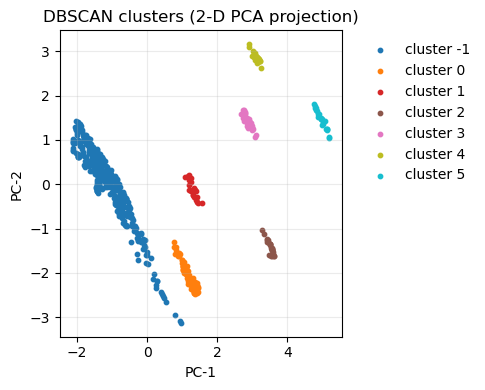

c:\Users\bdscu\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\bdscu\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


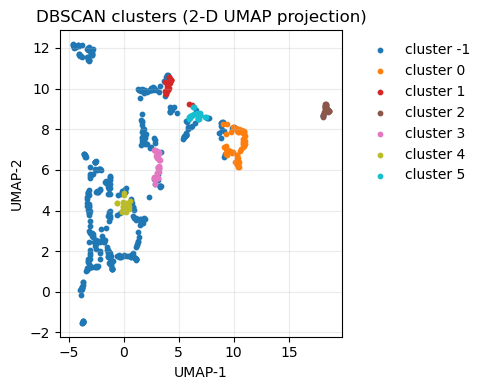

In [31]:
df_reduced.columns = df_reduced.columns.astype(str)
# 0.45, 11
# 0.5,11
# 0.8, 31
# 0.85, 12

# 0.6, 23

# umap2: .35, 15
# -----------------------------------------
# 5. Fit DBSCAN
# -----------------------------------------
EPS         = 0.6  #5 <-- pick from plot (example value)
MIN_SAMPLES = 23 # rule‑of‑thumb: D+1 to 2·D   (D = #dimensions after PCA)

db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric="euclidean", n_jobs=-1)
labels = db.fit_predict(df_reduced)

# -----------------------------------------
# 6. Attach labels & inspect
# -----------------------------------------
df_unscaled["Cluster"] = labels            # −1 are noise / outliers
print(df_unscaled["Cluster"].value_counts(dropna=False))
df_scaled_robust["Cluster"] = labels            # −1 are noise / outliers
# df_scaled["Cluster"] = labels 
df_reduced["Cluster"] = labels            # −1 are noise / outliers

# -----------------------------------------
# 7. 2‑D projection for visual sanity check
# -----------------------------------------
if df_reduced.shape[1] > 2:
    X_vis = PCA(n_components=2, random_state=42).fit_transform(df_reduced)
else:
    X_vis = df_reduced


unique_lbls = np.unique(labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_lbls)))

fig, ax = plt.subplots(figsize=(5, 4))
for l, c in zip(unique_lbls, colors):
    mask = labels == l
    ax.scatter(X_vis[mask, 0], X_vis[mask, 1],
               s=10, color=c, label=f"cluster {l}")
ax.set_title("DBSCAN clusters (2‑D PCA projection)")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left", frameon=False)
ax.set_xlabel("PC‑1"); ax.set_ylabel("PC‑2"); ax.grid(alpha=.25)
plt.tight_layout(); plt.show()


# ────────────────────────────────────────────────────────────────────────────────
# Example 1: UMAP projection for visualizing your existing DBSCAN clusters
# ────────────────────────────────────────────────────────────────────────────────
import umap
import matplotlib.pyplot as plt

# 1. Fit UMAP on your reduced data (df_reduced without the 'Cluster' column)
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(df_reduced.drop(columns=["Cluster"]))

# 2. Build a small DataFrame for plotting
df_umap = pd.DataFrame(X_umap, columns=["UMAP-1", "UMAP-2"])
df_umap["Cluster"] = labels

# 3. Scatter‐plot, coloring by DBSCAN label
unique_lbls = np.unique(labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_lbls)))

fig, ax = plt.subplots(figsize=(5, 4))
for lbl, col in zip(unique_lbls, colors):
    mask = df_umap["Cluster"] == lbl
    ax.scatter(df_umap.loc[mask, "UMAP-1"],
               df_umap.loc[mask, "UMAP-2"],
               s=10, color=col, label=f"cluster {lbl}")
ax.set_title("DBSCAN clusters (2-D UMAP projection)")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left", frameon=False)
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()


In [ ]:
# df_unscaled.to_csv(r"clustered_data/_unscaled_clustered_data4.csv")
# df_scaled_robust.to_csv(r"clustered_data/scaled_clustered_data4.csv")

In [14]:
import diagnoses
import pandas as pd
df_reduced_eval = df_reduced[df_reduced["Cluster"] != -1]
diagnoses.evaluate_clustering(df_reduced_eval, df_reduced_eval["Cluster"])

Silhouette Score:       0.7423
Davies–Bouldin Score:   0.3734
Calinski–Harabasz Score:1024.4280


{'silhouette': 0.7423162329767963,
 'davies_bouldin': 0.3733859286492917,
 'calinski_harabasz': 1024.4280466873731}

In [15]:
feature_high_z_scores = list(diagnoses.find_cluster_feature_zscore(df_scaled_robust, cluster_col='Cluster',z_score_cutoff=1.5)["feature"].unique())

In [107]:
feature_high_z_scores.remove("time_in_zone_P2_mean")


ValueError: list.remove(x): x not in list

In [3]:
feature_high_z_scores = ['percent_in_zone_P2_mean',
 'percent_in_zone_P3_mean',
 'max_heartrate_mean',
 'power_fatigue_index_mean',
 'a_skiba_xpower_mean',
 'a_skiba_response_index_mean',
 'a_friel_efficiency_factor_mean',
 '2m_critical_power_mean',
 '20m_critical_power_mean',
 '60m_critical_power_mean',
 'percent_in_zone_P4_mean',
]


In [32]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import diagnoses
unscaled_cluster = pd.read_csv("clustered_data\_unscaled_clustered_data3.csv", index_col=0)
cluster = unscaled_cluster["Cluster"]
unscaled_cluster = unscaled_cluster.drop(columns=["Cluster"])
X_scaled = StandardScaler().fit_transform(unscaled_cluster)  # X must be numeric and 2D
scaled_cluster = pd.DataFrame(X_scaled, columns=list(unscaled_cluster.columns), index=unscaled_cluster.index)
scaled_cluster["Cluster"] = cluster 

In [33]:
diagnoses.find_cluster_feature_zscore(scaled_cluster, cluster_col='Cluster',z_score_cutoff=2)["feature"].unique()

array(['efficiency_index_mean', 'a_skiba_variability_index_std',
       'percent_in_zone_P2_mean'], dtype=object)

In [34]:
z_scores_validation = diagnoses.find_cluster_feature_zscore(df_scaled_robust, cluster_col='Cluster',z_score_cutoff=2)

In [35]:
z_scores_df = pd.read_csv(r'z_scores_dbscan\z_score_cp_skiba4.csv')

In [13]:
# Count how many z_scores fall into each bin
#  Filter z_scores > 1
z_scores_filtered = z_scores_validation[z_scores_validation['z_score'] > 1]

# Define bins and labels
bins = [1, 2, 3, float('inf')]
labels = ['1-2', '2-3', '>3']

# Count how many z_scores fall into each bin
bin_counts = pd.cut(z_scores_filtered['z_score'], bins=bins, labels=labels).value_counts().sort_index()

print(bin_counts)


NameError: name 'z_scores_validation' is not defined

In [14]:
z_score_cluster_non_index = z_scores_df.reset_index()

In [15]:
z_scores_df_without_outliers = z_score_cluster_non_index[z_score_cluster_non_index['Cluster'] != -1]

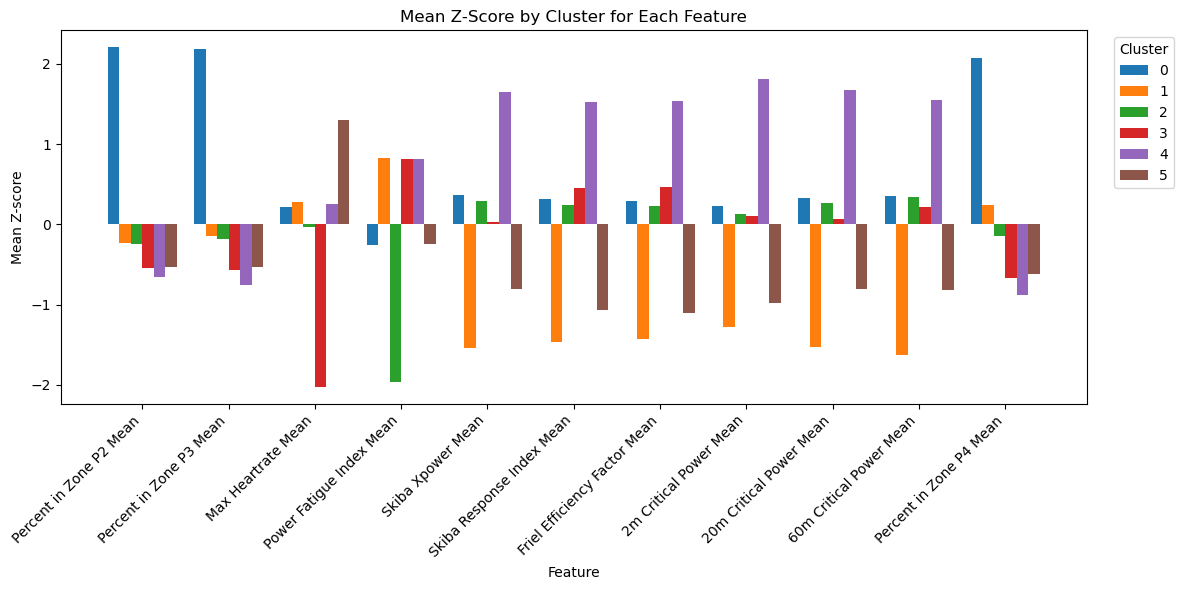

In [41]:
# feature_high_z_scores
# distinguishing_features 
# importlib.reload(diagnoses)
z_scores_df = diagnoses.cluster_zscore_dataframe(z_scores_df_without_outliers, features = feature_high_z_scores, cluster_col='Cluster')
diagnoses.plot_clusters_by_feature_matplotlib(z_scores_df, 
    feature_labels = features_rename)
# z_scores_df.to_csv(r"z_score_cp_skiba.csv")

In [32]:
z_scores_df.reset_index(inplace=True)

In [33]:
z_scores_df

,Cluster,percent_in_zone_P2_mean,percent_in_zone_P3_mean,max_heartrate_mean,power_fatigue_index_mean,a_skiba_xpower_mean,a_skiba_response_index_mean,a_friel_efficiency_factor_mean,2m_critical_power_mean,20m_critical_power_mean,60m_critical_power_mean,percent_in_zone_P4_mean
0,-1,-0.238754,-0.217920,0.204527,0.233020,0.078152,0.091204,0.118177,0.198670,0.105304,0.063981,-0.179269
1,0,2.086312,1.930177,-0.273481,-0.642745,0.093519,-0.007095,-0.079937,-0.288668,-0.005173,0.096619,1.530527
2,1,-0.118913,-0.048463,-0.234135,0.070589,-1.704827,-1.611352,-1.598744,-1.518023,-1.708784,-1.745360,0.255763
3,2,-0.131506,-0.083287,-0.414130,-1.756556,0.015864,-0.066292,-0.135505,-0.371916,-0.054165,0.083455,-0.016752
4,3,-0.400099,-0.408935,-1.549437,0.060288,-0.224436,0.120347,0.070467,-0.393170,-0.239813,-0.034026,-0.382908
5,4,-0.509792,-0.561770,-0.249211,0.058396,1.298490,1.086792,1.024544,1.000940,1.233305,1.207497,-0.530602
6,5,-0.394679,-0.370436,0.349976,-0.633365,-1.014743,-1.249540,-1.321549,-1.276122,-1.045163,-0.988163,-0.349491


In [ ]:
feature_high_z_scores = ['percent_in_zone_P2_mean',
 'percent_in_zone_P3_mean',
 'max_heartrate_mean',
 'power_fatigue_index_mean',
 'a_skiba_xpower_mean',
 'a_skiba_response_index_mean',
 'a_friel_efficiency_factor_mean',
 '2m_critical_power_mean',
 '20m_critical_power_mean',
 '60m_critical_power_mean',
 'percent_in_zone_P4_mean',
]

import numpy as np
import matplotlib.pyplot as plt

def plot_radar(df,
               features,
               cluster_col='Cluster',
               clusters_to_plot=None,
               title='Cluster Centroids Radar',
               archetypes=None,
               cluster_colors=None,
               feature_label_dict=None,
               show_feature_labels=False):
    """
    df                  : pandas.DataFrame containing your data + a cluster column
    features            : list of column names (all numeric, ideally z-scored)
    cluster_col         : name of the column holding cluster labels (expects ints ≥ 0)
    clusters_to_plot    : list of int cluster labels to include (default: all)
    title               : plot title
    archetypes          : dict mapping int cluster labels → string names
    cluster_colors      : dict mapping cluster label → color string (e.g. {0: 'red', 1: 'blue'})
    feature_label_dict  : dict mapping original feature names → display names
    show_feature_labels : bool, if True, draw feature names at each axis tick
    """

    # default archetype names
    if archetypes is None:
        archetypes = {
            0: "Rouleur",
            1: "Climber",
            2: "Time Trialist",
            3: "Domestique",
            4: "All-Rounder",
            5: "Puncheur"
        }

    # default cluster color mapping
    if cluster_colors is None:
        cluster_colors = {
            0: 'red',
            1: 'blue',
            2: 'green',
            3: 'orange',
            4: 'purple',
            5: 'cyan'
        }

    # 1) Compute centroids for each cluster
    centroids = (
        df[df[cluster_col] >= 0]
        .groupby(cluster_col)[features]
        .mean()
    )

    # 2) Filter clusters if needed
    if clusters_to_plot is not None:
        centroids = centroids.loc[clusters_to_plot]

    # 3) Set radar chart angles
    N = len(features)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    # 4) Draw radar chart
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    for cl in centroids.index:
        vals = centroids.loc[cl].tolist()
        vals += vals[:1]
        name = archetypes.get(cl, f'Cluster {cl}')
        color = cluster_colors.get(cl, 'gray')
        ax.plot(angles, vals, label=name, color=color)
        ax.fill(angles, vals, color=color, alpha=0.1)

    # 5) Final touches: custom or fallback labels
    ax.set_xticks(angles[:-1])
    if show_feature_labels:
        if feature_label_dict:
            pretty_labels = [ feature_label_dict.get(feat, feat).replace('_', ' ')
                              for feat in features ]
        else:
            pretty_labels = [ feat.replace('_', ' ') for feat in features ]
    else:
        pretty_labels = [''] * N
    ax.set_xticklabels(pretty_labels)

    ax.set_title(title, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize='small')
    plt.tight_layout()
    plt.show()


In [36]:
features_rename = {'percent_in_zone_P2_mean' : 'Percent in Zone P2 Mean',
 'percent_in_zone_P3_mean' : 'Percent in Zone P3 Mean',
 'max_heartrate_mean' : 'Max Heartrate Mean',
 'power_fatigue_index_mean' : 'Power Fatigue Index Mean',
 'a_skiba_xpower_mean' : 'Skiba Xpower Mean',
 'a_skiba_response_index_mean' : 'Skiba Response Index Mean',
 'a_friel_efficiency_factor_mean' : 'Friel Efficiency Factor Mean',
 '2m_critical_power_mean' : '2m Critical Power Mean',
 '20m_critical_power_mean' : '20m Critical Power Mean',
 '60m_critical_power_mean' : '60m Critical Power Mean',
 'percent_in_zone_P4_mean' : 'Percent in Zone P4 Mean',
        }

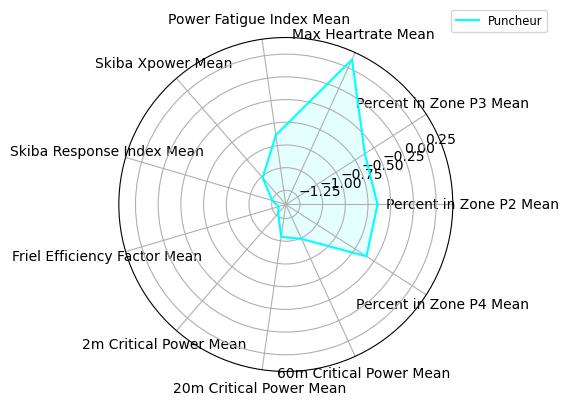

In [37]:

plot_radar(z_scores_df,features=feature_high_z_scores, title="", clusters_to_plot=[5], cluster_col='Cluster', 
        feature_label_dict= features_rename,
        show_feature_labels=True)

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def plot_radar(df,
               features,
               cluster_col='Cluster',
               clusters_to_plot=None,
               title='Cluster Centroids Radar',
               archetypes=None,
               cluster_colors=None,
               show_feature_labels=False):
    """
    df                 : pandas.DataFrame containing your data + a cluster column
    features           : list of column names (all numeric, ideally z-scored)
    cluster_col        : name of the column holding cluster labels (expects ints ≥ 0)
    clusters_to_plot   : list of int cluster labels to include (default: all)
    title              : plot title
    archetypes         : dict mapping int cluster labels → string names
    cluster_colors     : dict mapping cluster label → color string
    show_feature_labels: bool, if True, draw feature names at each axis tick
    """

    # default archetype names
    if archetypes is None:
        archetypes = {
            0: 0,
            1: 1,
            2: 2,
            3: 3,
            4: 4,
            5: 5
        }

    # default cluster color mapping
    if cluster_colors is None:
        cluster_colors = {
            0: 'red',
            1: 'blue',
            2: 'green',
            3: 'orange',
            4: 'purple',
            5: 'cyan'
        }

    # 1) Compute centroids for all clusters (for global scale) and then for subset
    all_centroids = (
        df[df[cluster_col] >= 0]
        .groupby(cluster_col)[features]
        .mean()
    )
    # apply subset filter if requested
    centroids = all_centroids if clusters_to_plot is None else all_centroids.loc[clusters_to_plot]

    # 2) Determine global min/max across all cluster centroids & features
    global_min = all_centroids.values.min()
    global_max = all_centroids.values.max()

    # 3) Set up the radar chart angles
    N = len(features)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    # 4) Draw radar chart
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    # fix radial limits to the global range
    ax.set_ylim(global_min, global_max)

    for cl in centroids.index:
        vals = centroids.loc[cl].tolist()
        vals += vals[:1]
        name = archetypes.get(cl, f'Cluster {cl}')
        color = cluster_colors.get(cl, 'gray')
        ax.plot(angles, vals, label=name, color=color)
        ax.fill(angles, vals, color=color, alpha=0.1)

    # 5) Final touches
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features if show_feature_labels else [''] * N)
    ax.set_title(title, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize='small')
    plt.tight_layout()
    plt.show()


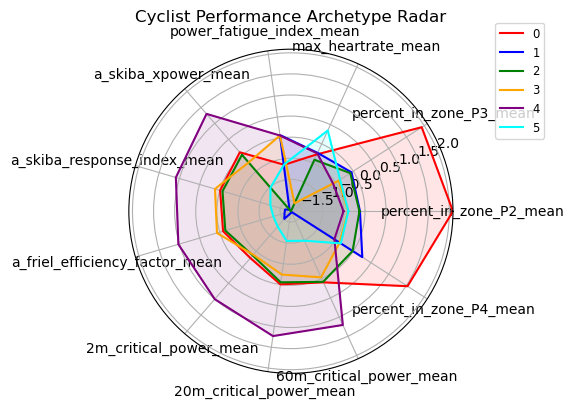

In [74]:
plot_radar(z_scores_df,features=feature_high_z_scores, title="Cyclist Performance Archetype Radar" ,cluster_col='Cluster', show_feature_labels=True)

In [19]:
import diagnoses
# importlib.reload(diagnoses)

distinguishing_features = [
'1s_critical_power_mean',
'20m_critical_power_mean',
'60m_critical_power_mean',
'skiba_wprime_exp_mean',
'a_skiba_variability_index_mean',
'a_friel_efficiency_factor_mean',
'aerobic_decoupling_mean',
'vo2max_mean',
'athlete_weight_mean', 
'a_skiba_bike_score_mean'
]
# diagnoses.create_violinplots_by_cluster(df_unscaled, feature_cols= distinguishing_features,  cluster_col = "Cluster")


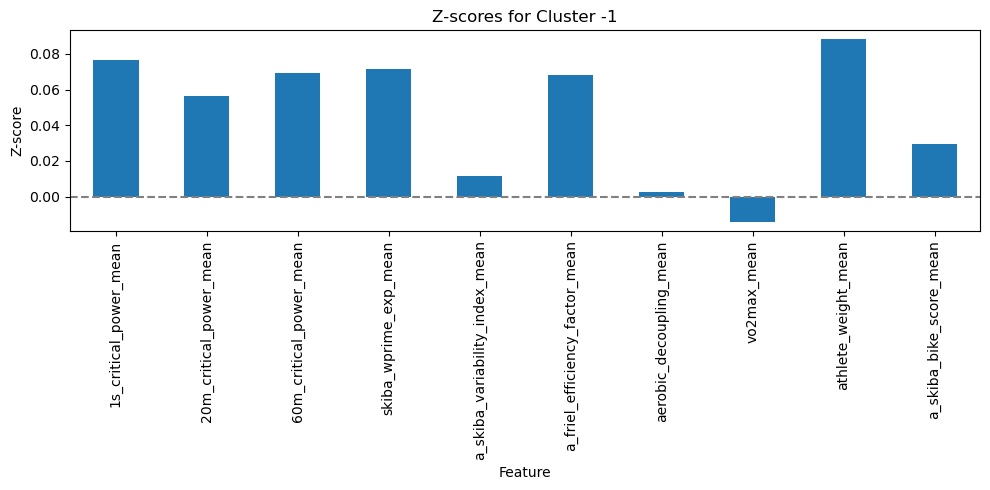

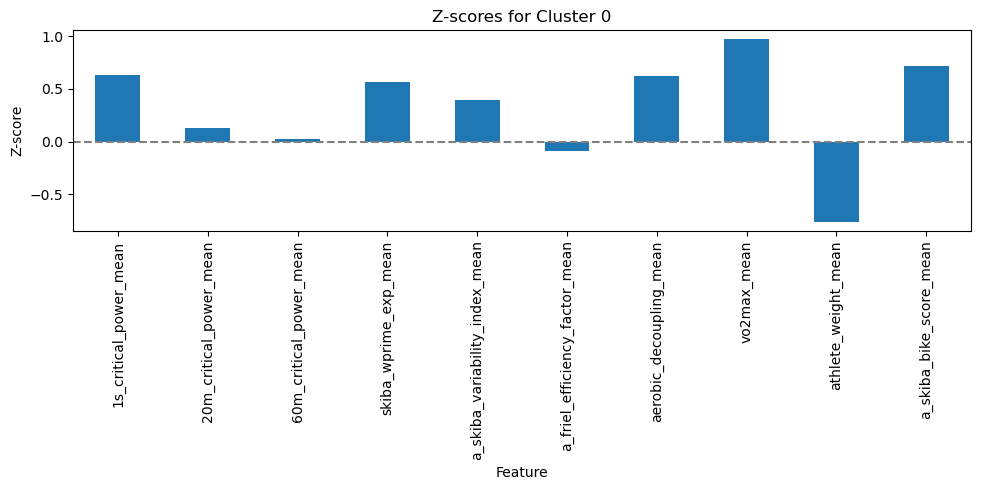

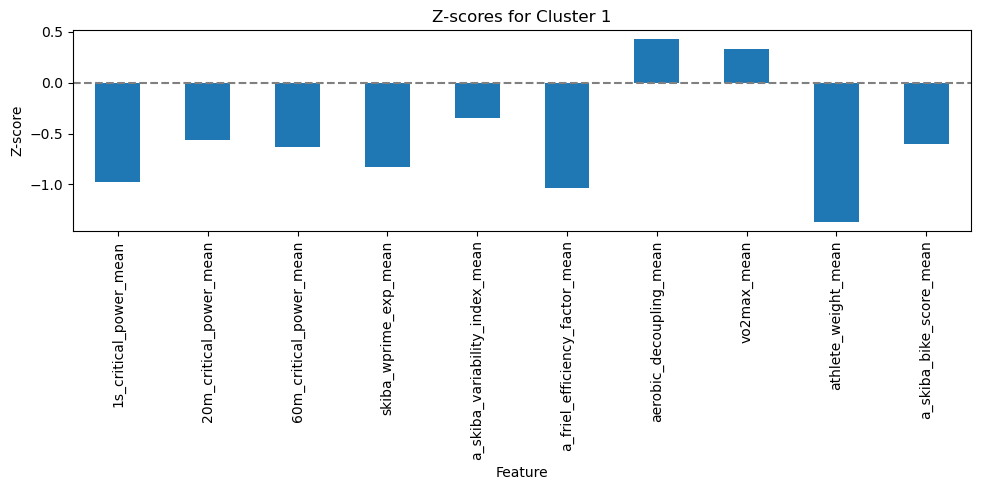

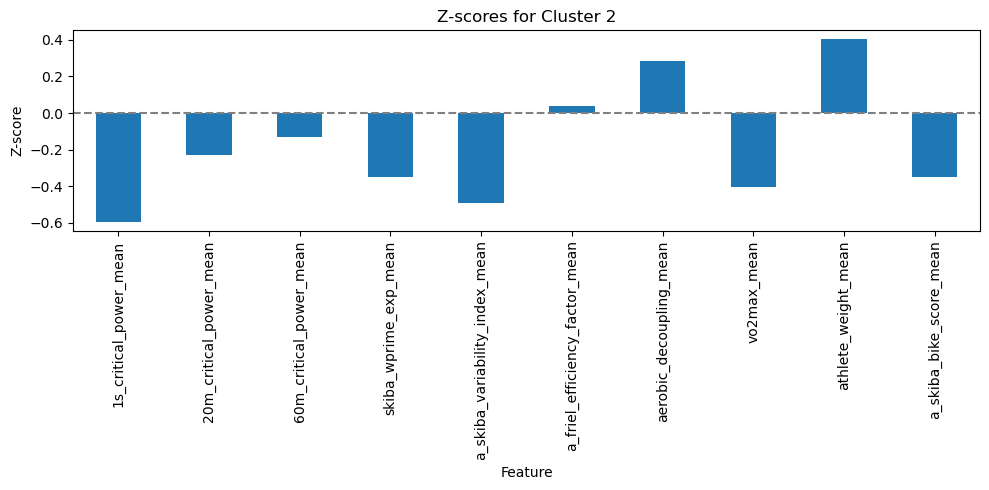

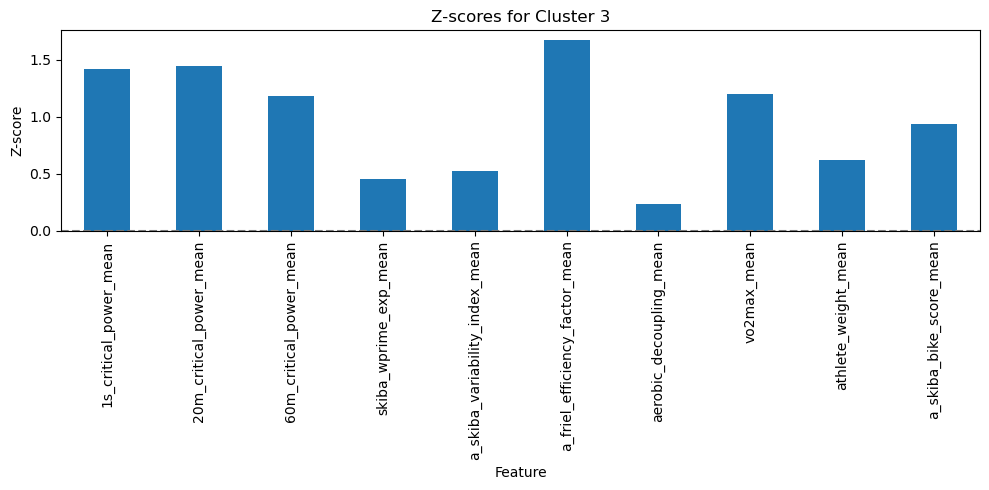

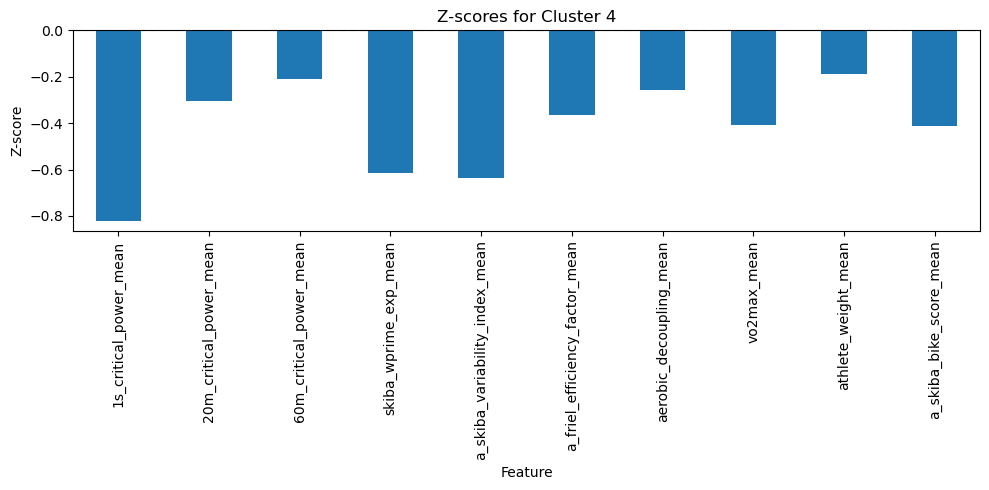

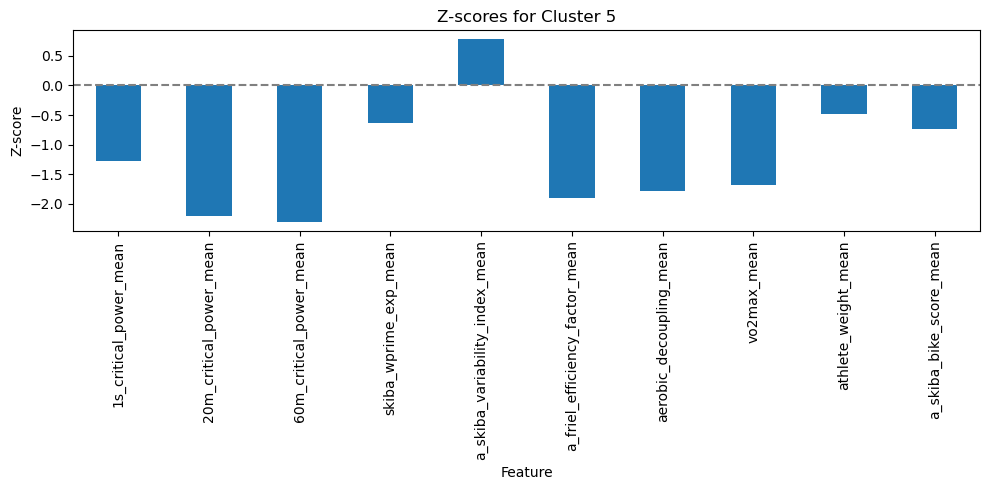

{'1s_critical_power_mean': {-1: 0.0764400583466143,
  0: 0.6347224811332428,
  1: -0.9719133385886053,
  2: -0.5939251371911023,
  3: 1.4146318207546096,
  4: -0.8224966980726759,
  5: -1.2757733824881576},
 '20m_critical_power_mean': {-1: 0.056363144101718395,
  0: 0.13270395333070922,
  1: -0.5596713735722212,
  2: -0.23050890365222693,
  3: 1.4422158789363277,
  4: -0.30652906834648996,
  5: -2.203368913467809},
 '60m_critical_power_mean': {-1: 0.06908033861910054,
  0: 0.02333982545757174,
  1: -0.6357772045517603,
  2: -0.1300989403120422,
  3: 1.1777092922016177,
  4: -0.2106307360136913,
  5: -2.299211260223406},
 'skiba_wprime_exp_mean': {-1: 0.07147117746797647,
  0: 0.5623021964990388,
  1: -0.8258044728506744,
  2: -0.3471871004798465,
  3: 0.45480992933041864,
  4: -0.6137318562908518,
  5: -0.6280058459874794},
 'a_skiba_variability_index_mean': {-1: 0.011566375506424113,
  0: 0.39648106492233537,
  1: -0.3418936656760241,
  2: -0.49388948204561156,
  3: 0.5238685143672245

In [ ]:
zscores = diagnoses.compute_cluster_zscores(df_unscaled, feature_cols= distinguishing_features, cluster_col = 'Cluster')
zscores.to_dict()

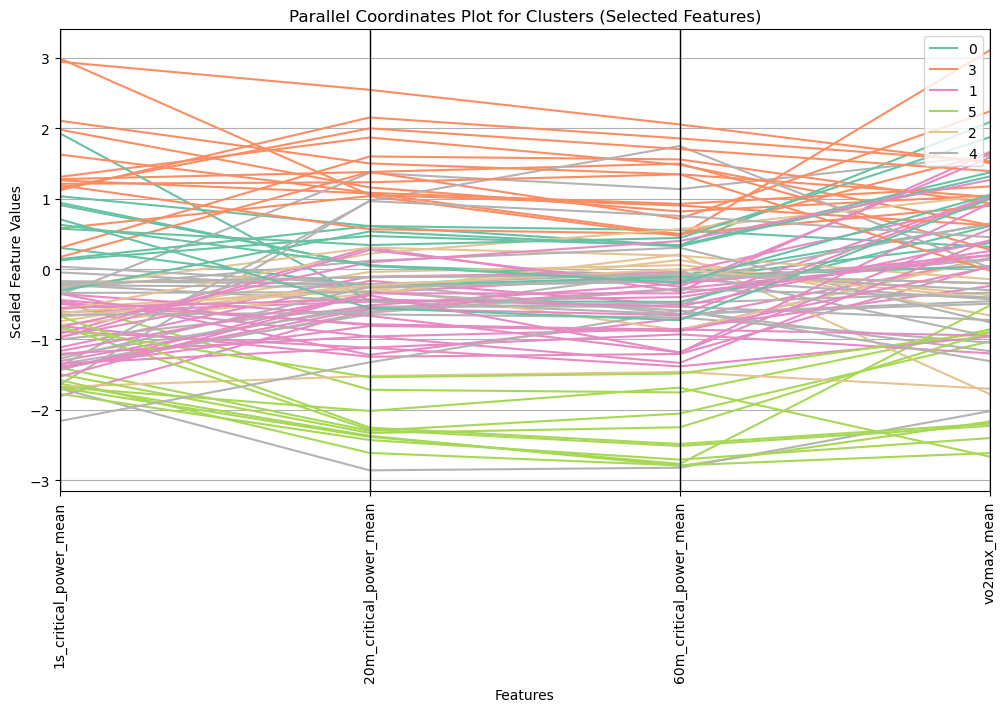

In [ ]:
parallel_plot_features = [
'1s_critical_power_mean',
'20m_critical_power_mean',
'60m_critical_power_mean',
# 'a_skiba_variability_index_mean',
# 'a_friel_efficiency_factor_mean',
# 'aerobic_decoupling_mean',
'vo2max_mean'
]
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

# 1) Subset your scaled DataFrame to only the distinguishing features + the cluster label
df_unscaled_filtered = df_scaled[df_scaled['Cluster'] != -1].copy()
cols_to_plot = parallel_plot_features + ['Cluster']
df_plot = df_unscaled_filtered[cols_to_plot]

# 2) Plot
plt.figure(figsize=(12, 6))
parallel_coordinates(df_plot, 'Cluster', colormap=plt.get_cmap("Set2"))
plt.title("Parallel Coordinates Plot for Clusters (Selected Features)")
plt.xlabel("Features")
plt.ylabel("Scaled Feature Values")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


In [31]:
print(list(df_unscaled.columns))

['a_skiba_xpower_mean', 'a_skiba_xpower_std', 'a_skiba_relative_intensity_mean', 'a_skiba_relative_intensity_std', 'a_skiba_bike_score_mean', 'a_skiba_bike_score_std', 'a_skiba_variability_index_mean', 'a_skiba_variability_index_std', 'a_skiba_response_index_mean', 'a_skiba_response_index_std', 'a_friel_efficiency_factor_mean', 'a_friel_efficiency_factor_std', 'a_coggan_tssperhour_mean', 'aerobic_decoupling_mean', 'aerobic_decoupling_std', 'time_riding_mean', 'time_riding_std', 'athlete_weight_mean', 'elevation_gain_mean', 'average_power_max', 'nonzero_power_mean', 'nonzero_power_std', 'average_hr_mean', 'average_hr_std', 'average_hr_min', 'average_hr_max', 'wb_mean', 'hrnp_mean', 'hrnp_std', 'hrnp_min', 'average_cad_mean', 'max_heartrate_mean', 'max_heartrate_std', 'max_cadence_mean', 'ninety_five_percent_hr_mean', 'eoa_mean', 'meanpowervariance_mean', 'maxpowervariance_mean', 'activity_crc_mean', 'activity_crc_std', 'atiss_score_mean', 'antiss_score_mean', 'cp_setting_mean', 'tiss_de

In [ ]:
X = df_unscaled_filtered[distinguishing_features].copy()
y = df_unscaled_filtered['Cluster'].copy()
rf_model, rf_rules = surrogate_rules_and_pdp_ensemble(
    X, y,
    pdp_features=["1min_critical_power_mean"],
    target=3,               # cluster label 3
    model_type="rf",
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=10,
    random_state=42
)


NameError: name 'surrogate_rules_and_pdp_ensemble' is not defined

In [ ]:
# importlib.reload(diagnoses)
diagnoses.plot_feature_distribution(data=df_unscaled_filtered, feature='1s_critical_power_mean')

NameError: name 'df_unscaled_filtered' is not defined

In [ ]:
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

def surrogate_rules_and_pdp_ensemble(
    X,
    y,
    pdp_features,
    target=None,
    model_type="rf",           # "rf" or "gb"
    n_estimators=100,
    max_depth=3,
    min_samples_leaf=20,
    learning_rate=0.1,         # only for GB
    random_state=42,
    response_method="auto"
):
    """
    1) Fits a RandomForestClassifier or GradientBoostingClassifier to (X, y)
    2) Prints the rules of the *first* tree
    3) Plots PDP for pdp_features on the specified class (target)
    """
    # 1) instantiate
    if model_type == "rf":
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state
            
        )
    elif model_type == "gb":
        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state
        )
    else:
        raise ValueError("model_type must be 'rf' or 'gb'")
    
    # 2) fit
    model.fit(X, y)

    # 3) extract & print rules from the *first* tree
    #    RandomForestClassifier: .estimators_[0]
    #    GradientBoostingClassifier: .estimators_[0, 0]
    if model_type == "rf":
        base_tree = model.estimators_[0]
    else:  # gb
        base_tree = model.estimators_[0, 0]
    rules = export_text(base_tree, feature_names=list(X.columns))
    print(f"Surrogate {model_type} – first tree rules:\n", rules)

    # 4) plot PDP
    PartialDependenceDisplay.from_estimator(
        model, X, pdp_features, target=target, kind="both", response_method=response_method,
    )
    plt.tight_layout()
    plt.show()

    return model, rules


In [52]:

for cluster_id, group in df_scaled[feature_high_z_scores + ['Cluster']].groupby('Cluster'):
    # You can choose 'pearson' or 'spearman' here
    corr_matrix = group.drop(columns='Cluster').corr(method='pearson')
    # Plotting
    plt.figure(figsize=(10, 8))
    plt.title(f'Cluster {cluster_id} Correlation Heatmap')
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Correlation')
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.tight_layout()


NameError: name 'df_scaled' is not defined